## Using Tracker

In this notebook, I'll demonstrate using `Tracker` and related features of `orcabridge` to keep *track* of all `operations` you are using in a pipeline and to automatically construct computation graph based on it.

In [1]:
from orcabridge.tracker import Tracker
from orcabridge.source import GlobSource
from orcabridge.pod import FunctionPodWithDirStorage
import orcabridge.mapper as router
import networkx as nx
import matplotlib.pyplot as plt

As before let's construct a simple data pipeline that reads files and counts the number of lines, saving that information into another file. We will then chain it with another function that converts JSON to YAML.

In [2]:
gs = GlobSource("data_file", "../examples/dataset1", "*.txt")

In [3]:
import tempfile
from pathlib import Path
import json
import yaml


# function to count lines in a file and save it as JSON
def count_lines(file: str):
    with open(file, "r") as f:
        n = len(f.readlines())
    tmp_dir = tempfile.mkdtemp()
    data_file = Path(tmp_dir) / "data.json"
    data = dict(lines=n)
    with open(data_file, "w") as f:
        json.dump(data, f)
    return data_file


def json_to_yaml(json_file: str):
    with open(json_file, "r") as f:
        data = json.load(f)
    tmp_dir = tempfile.mkdtemp()
    yaml_path = Path(tmp_dir) / Path(json_file).with_suffix(".yaml").name
    with open(yaml_path, "w") as f:
        yaml.dump(data, f)
    return yaml_path

In [4]:
# prepare a few MapKey mappers to take care of name differences
rename_to_file = router.MapKeys({"data_file": "file"})

count_fp = FunctionPodWithDirStorage(count_lines, ["stats"])

rename_to_json = router.MapKeys({"stats": "json_file"})

convert_fp = FunctionPodWithDirStorage(json_to_yaml, ["yaml_file"])

With all steps defined, let's chain them together to form a full pipeline.

In [5]:
line_info_json = count_fp(rename_to_file(gs))
line_info_yaml = convert_fp(rename_to_json(line_info_json))

In [6]:
line_info_yaml.preview(0)

Tag: {'file_name': 'day1'}, Packet: {'yaml_file': 'pod_data/json_to_yaml/16207fa7-72aa-be99-3d44-e034a5ba8823/data.yaml'}
Tag: {'file_name': 'day2'}, Packet: {'yaml_file': 'pod_data/json_to_yaml/6c450b34-8835-afa9-2c07-c2d214749c3b/data.yaml'}
Tag: {'file_name': 'day3'}, Packet: {'yaml_file': 'pod_data/json_to_yaml/21c8f435-47d2-13ee-cdb2-9c31eb54093b/data.yaml'}
Tag: {'file_name': 'day4'}, Packet: {'yaml_file': 'pod_data/json_to_yaml/9f94dfb0-bded-6e79-dea1-494515af4886/data.yaml'}


It turns out that `orcabrdige` comes with a default tracker that's been tracking all the execution that's been going on all this time!

In [7]:
from orcabridge import DEFAULT_TRACKER

We can generate computation graph and appropriate name labels from the `DEFAULT_TRACKER` and plot it out.

In [8]:
G = DEFAULT_TRACKER.generate_graph()
labels = DEFAULT_TRACKER.generate_namemap()

/tmp/ipykernel_2655506/828196166.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


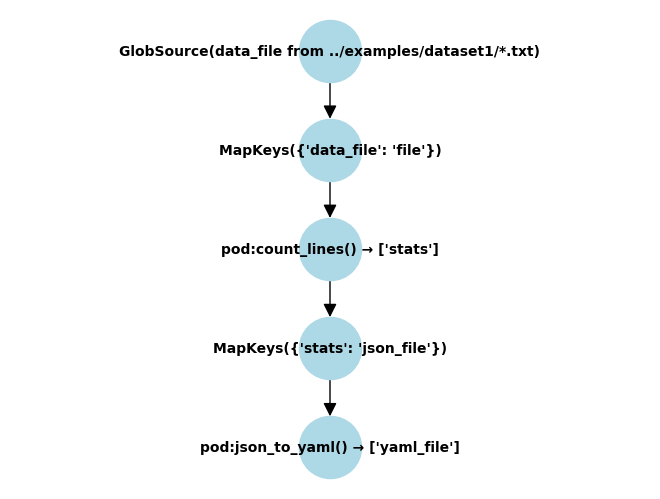

In [9]:
pos = nx.drawing.nx_agraph.graphviz_layout(G, prog="dot")
nx.draw(
    G,
    pos,
    labels=labels,
    node_size=2000,
    node_color="lightblue",
    with_labels=True,
    font_size=10,
    font_weight="bold",
    arrowsize=20,
)
plt.tight_layout()

## Explicitly tracking computation pipeline with a tracker

While the `DEFAULT_TRACKER` offers a nice catch-all tracker, sometimes you'd want to explicitly control what gets tracked. To do so, you would want to create your own tracker, and define the computation using the tracker's context manager. Let's see an example.

In [10]:
# instantiate a new tracker
tracker = Tracker()

# start a context manager to track the pipeline
with tracker:
    # chain the operations into a pipeline inside the context manager
    line_info_json = count_fp(rename_to_file(gs))

# construct the latter half OUTSIDE of the context manager
line_info_yaml = convert_fp(rename_to_json(line_info_json))

In the example above, you would notice that only first half of the pipeline is chained together within the `tracker` context manager. Let's now see what the graph looks like.

/tmp/ipykernel_2655506/2248456176.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


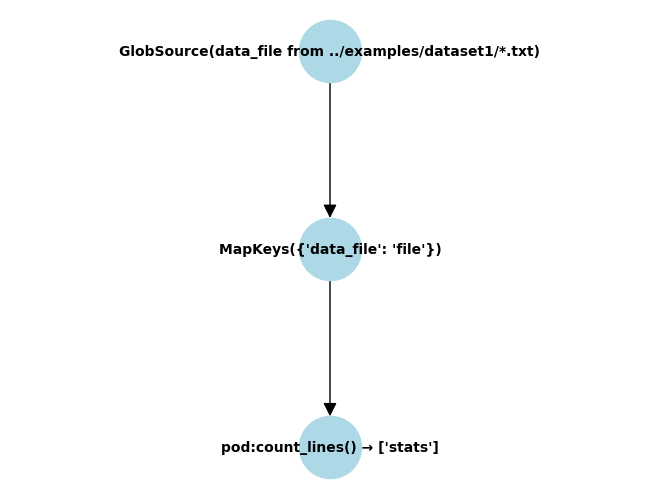

In [11]:
G = tracker.generate_graph()
labels = tracker.generate_namemap()

pos = nx.drawing.nx_agraph.graphviz_layout(G, prog="dot")
nx.draw(
    G,
    pos,
    labels=labels,
    node_size=2000,
    node_color="lightblue",
    with_labels=True,
    font_size=10,
    font_weight="bold",
    arrowsize=20,
)
plt.tight_layout()

As expected, the `tracker` only tracked the first half othe pipeline!